In [1]:
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

In [2]:
#read images
data=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())


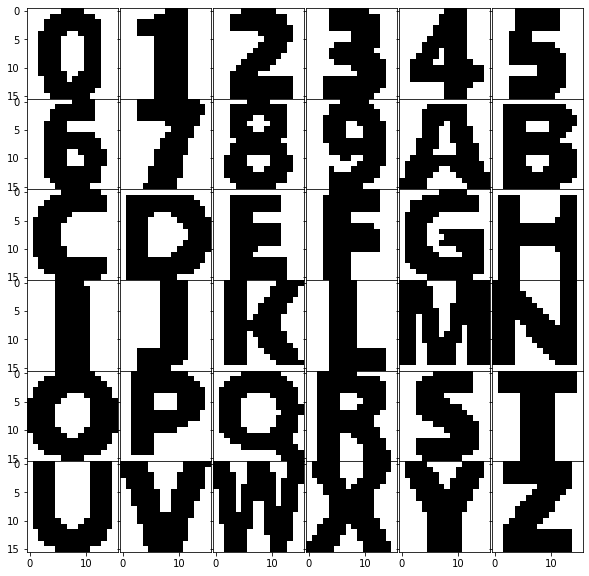

In [3]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(data[i].reshape(16, 16), 'gray')    

In [4]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))

/var/folders/9n/3xxt38bn37v0q9snx7htdy3r0000gn/T/ipykernel_61562/1365032627.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_new.cpp:201.)
  x_data = Variable(torch.Tensor([data]))


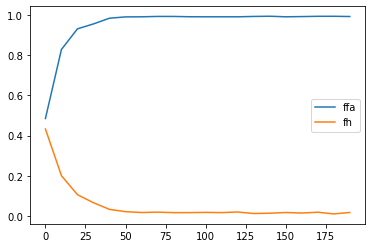

In [20]:
from model import DeepNet
from engine import test, train
ffa = []
fh = []
for epochs in range(0, 200, 10):
    model = DeepNet(layerSize=[256, 512, 1024, 512, 256])
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    train(data, data, model, criterion, optimizer, epochs)
    pred, err = test(data=data, target=data, model=model)
    ffa += [np.mean(err[0])]
    fh += [np.mean(err[1])]
plt.figure()
plt.plot(range(0, 200, 10), ffa, label='ffa')
plt.plot(range(0, 200, 10), fh, label='fh')
plt.legend()    

In [21]:
model = DeepNet(layerSize=[256, 512, 1024, 512, 256])
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
train(data, data, model, criterion, optimizer, 100)

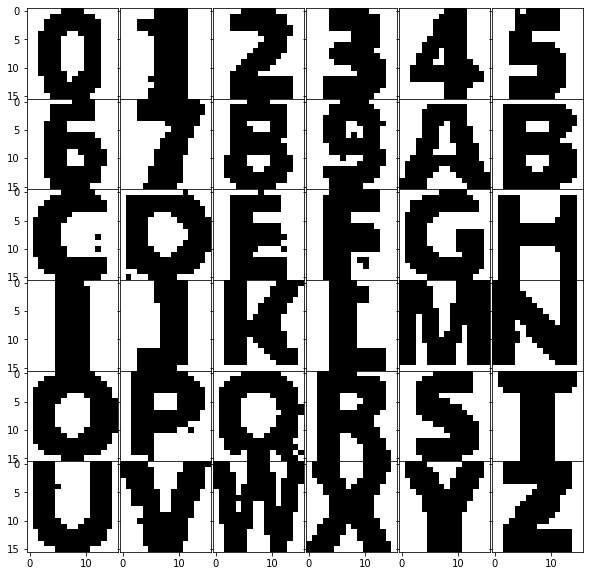

In [22]:
pred, err = test(data=data, target=data, model=model)
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    

In [7]:
#read images
serif=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/serif/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    serif.append(np.array(final_img, dtype=np.float32).flatten())


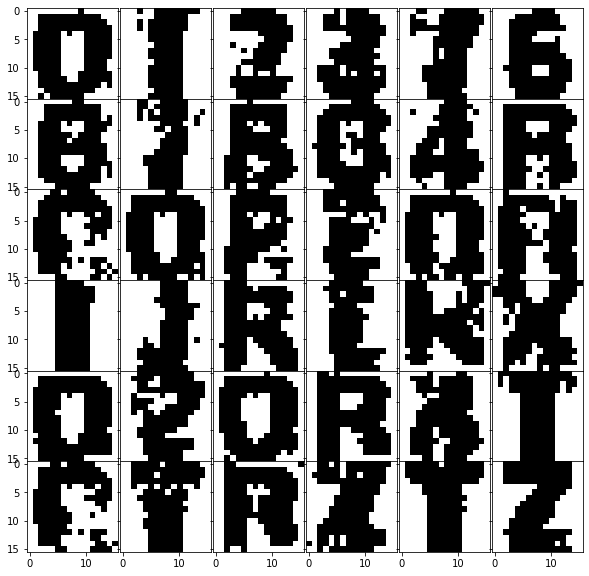

In [9]:
pred, err = test(data=serif, target=serif, model=model)
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    